<a href="https://colab.research.google.com/github/SeifxMahmoud/Teeth-Classification-TransferLearning-and-StremLit/blob/main/TransferLearning_and_Streamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
!pip install gdown


In [58]:
import requests
import zipfile
import gdown

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Flatten, Dense, Dropout, Activation, LSTM, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Reshape, multiply
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import numpy as np
import cv2
import os

tf.random.set_seed(25)

In [59]:
im = cv2.imread('/content/Teeth_Dataset/Training/CaS/a_100_0_5539.jpg')
print(im.shape)

(256, 256, 3)


In [60]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    '/content/Teeth_Dataset/Training',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/Teeth_Dataset/Validation',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Teeth_Dataset/Testing',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


Image shape: (32, 256, 256, 3)
Label shape: (32, 7)


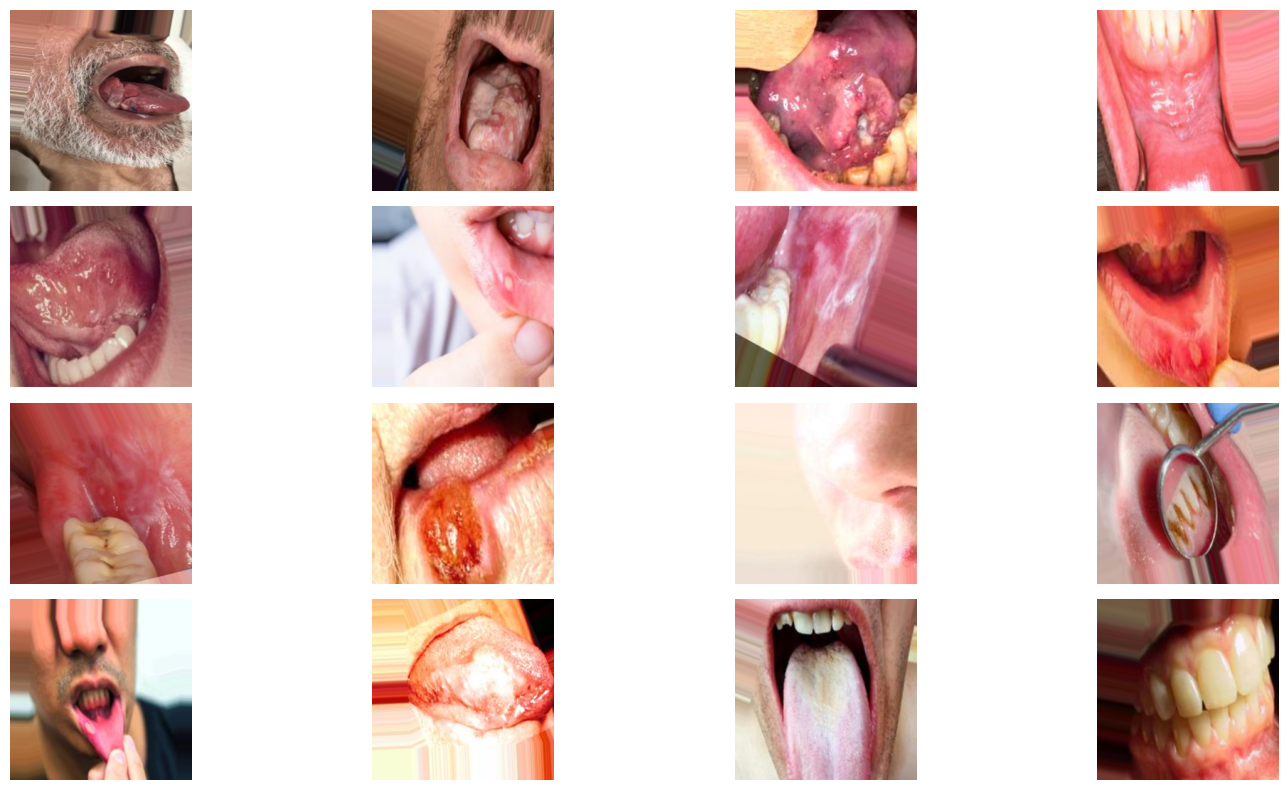

In [61]:
for x, y in train_generator:
    print("Image shape:", x.shape)
    print("Label shape:", y.shape)
    # Get the batch size
    batch_size = x.shape[0]

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 8))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for i in range(min(batch_size, 16)):
        # Convert image to RGB if necessary
        if x[i].shape[-1] == 1:
            image = np.squeeze(x[i], axis=-1)
        else:
            image = x[i]

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    break

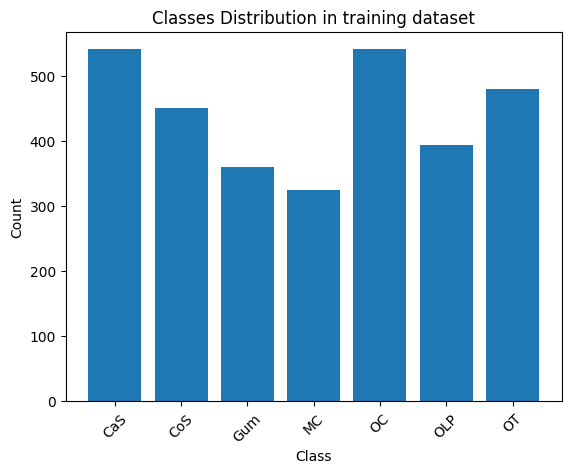

In [62]:
class_counts = []
for subfolder in os.listdir("/content/Teeth_Dataset/Training"):
    subfolder_path = os.path.join("/content/Teeth_Dataset/Training", subfolder)
    if os.path.isdir(subfolder_path):
      count = len(os.listdir(subfolder_path))
      class_counts.append(count)

# Get class names
class_names = list(train_generator.class_indices.keys())

# Create a bar chart
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Classes Distribution in training dataset')
plt.xticks(rotation=45)
plt.show()

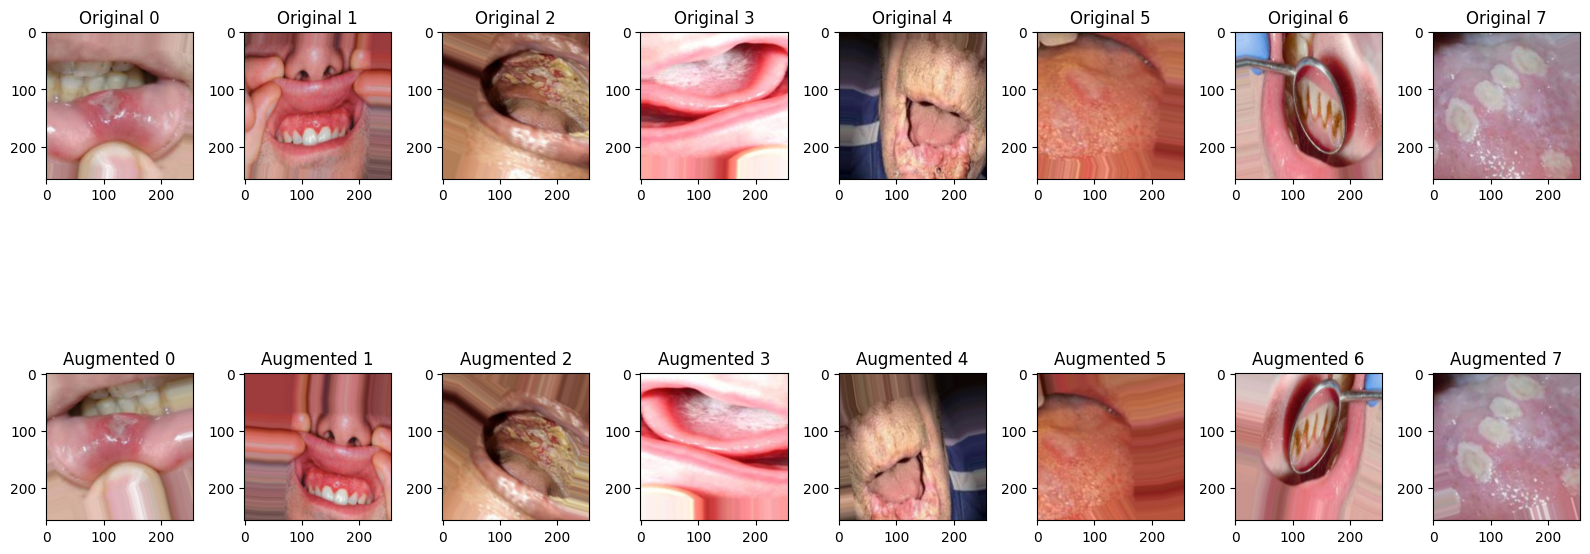

In [63]:
for x, y in train_generator:

    # Create a figure with two rows for displaying 8 images before and after
    fig, axes = plt.subplots(2, 8, figsize=(16, 8))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Iterate through the batch and display images
    for i in range(8):
        # Convert image to RGB if necessary (assuming grayscale handling)
        if x[i].shape[-1] == 1:
            original_img = np.squeeze(x[i], axis=-1)
        else:
            original_img = x[i]

        # Apply augmentations to the image
        augmented_img = train_datagen.random_transform(x[i])
        augmented_img = array_to_img(augmented_img)

        # Display original and augmented images
        axes[i].imshow(original_img)
        axes[i].set_title(f"Original {i}")
        axes[i + 8].imshow(augmented_img)
        axes[i + 8].set_title(f"Augmented {i}")

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()
    break

In [64]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [65]:
strategy = tf.distribute.MirroredStrategy(['gpu:0', 'gpu:1'])

In [66]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # Adjust to 7 classes
model =tf.keras.Model(inputs=base_model.input, outputs=predictions)


In [67]:
for layer in base_model.layers:
  layer.trainable= False

In [68]:
model.compile(optimizer= Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [74]:
class_weights = {}
for i in range(7):
    wieghted_class = max(class_counts)/class_counts[i]
    class_weights[i] = wieghted_class

In [75]:
class_weights

{0: 1.0,
 1: 1.2,
 2: 1.5,
 3: 1.6666666666666667,
 4: 1.0,
 5: 1.3740458015267176,
 6: 1.125}

In [76]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="/content/Teeth_Dataset/checkpoint.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [79]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    batch_size=32,
                    class_weight=class_weights,
                    callbacks=[model_checkpoint_callback])

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 558ms/step - accuracy: 0.1963 - loss: 2.5215 - val_accuracy: 0.1819 - val_loss: 1.9064
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 522ms/step - accuracy: 0.2042 - loss: 2.4200 - val_accuracy: 0.2335 - val_loss: 1.9396
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 525ms/step - accuracy: 0.2130 - loss: 2.3992 - val_accuracy: 0.1819 - val_loss: 1.8832
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 523ms/step - accuracy: 0.2241 - loss: 2.3536 - val_accuracy: 0.2374 - val_loss: 1.8369
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 513ms/step - accuracy: 0.2340 - loss: 2.3236 - val_accuracy: 0.2753 - val_loss: 1.8855
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 524ms/step - accuracy: 0.2309 - loss: 2.3558 - val_accuracy: 0.2091 - val_loss: 1.8881
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 80s 510ms/step - accuracy: 0.2192 - loss: 2.3358 - val_accuracy: 0.2568 - val_loss: 1.8337
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - accuracy: 0.2555 - loss: 2.3201 - val_accu

In [81]:
for layer in base_model.layers[-20:]: # Iterate from the 20th-to-last layer to the end
    layer.trainable = True

model.compile(optimizer= Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


history_fine_tuned= model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 80s 607ms/step - accuracy: 0.2057 - loss: 3.5637 - val_accuracy: 0.1761 - val_loss: 1.9674
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 66s 524ms/step - accuracy: 0.3188 - loss: 2.1335 - val_accuracy: 0.1469 - val_loss: 2.4019
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 517ms/step - accuracy: 0.3362 - loss: 2.1082 - val_accuracy: 0.1693 - val_loss: 2.4689
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 550ms/step - accuracy: 0.3565 - loss: 2.0434 - val_accuracy: 0.3317 - val_loss: 1.6641
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 526ms/step - accuracy: 0.3952 - loss: 1.9430 - val_accuracy: 0.4270 - val_loss: 1.4600
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 518ms/step - accuracy: 0.3902 - loss: 1.9282 - val_accuracy: 0.3560 - val_loss: 1.7191
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 517ms/step - accuracy: 0.4045 - loss: 1.8949 - val_accuracy: 0.3307 - val_loss: 1.8938
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 529ms/step - accuracy: 0.3883 - loss: 1.9163 - val_accu

In [82]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [83]:
model.save('trained_model.keras')

In [84]:
import pickle
with open('training_history.pk1', 'wb') as f:
  pickle.dump(history_fine_tuned.history, f)

2024-08-29 19:00:16.628 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 19:00:16.695 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-08-29 19:00:16.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 19:00:16.701 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 19:00:16.702 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 19:00:17.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 19:00:17.561 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 19:00:17.563 Thread 'MainThread': mi

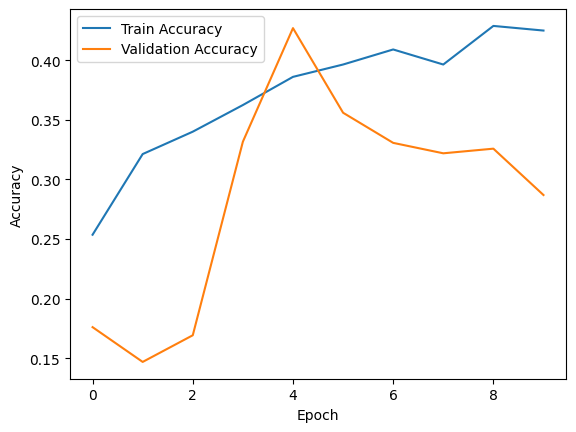

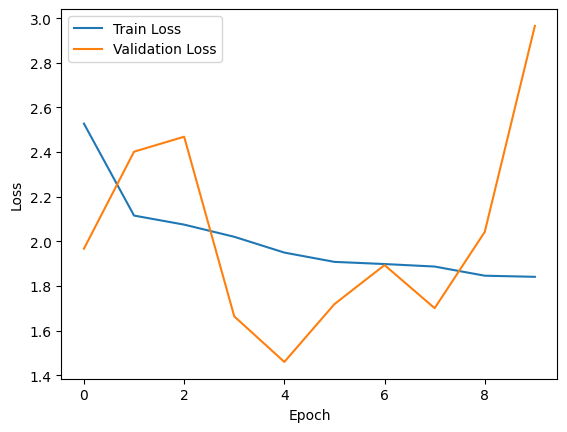

In [89]:
import streamlit as st
model = load_model('trained_model.keras')
with open('training_history.pk1', 'rb') as f: # Changed file name to match saved file
  history = pickle.load(f)

st.title('Model Training Results')

# Plot accuracy
st.subheader('Training and Validation Accuracy')
fig, ax = plt.subplots()
ax.plot(history['accuracy'], label='Train Accuracy')
ax.plot(history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
st.pyplot(fig)

# Plot loss
st.subheader('Training and Validation Loss')
fig, ax = plt.subplots()
ax.plot(history['loss'], label='Train Loss')
ax.plot(history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
st.pyplot(fig)

# Predict on a sample image
st.subheader('Sample Image Prediction')
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).resize((224, 224))  # Adjust size according to model input
    st.image(img, caption='Uploaded Image', use_column_width=True)

    # Prepare the image for prediction
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions[0])
    st.write(f"Predicted class index: {class_index}")

    # Optionally, display class labels if available
    class_labels = ['class_1', 'class_2', 'class_3']  # Replace with your actual class labels
    st.write(f"Predicted class label: {class_labels[class_index]}")
